In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3c6db9ef43f08f3cc99b56258117a9f104a5db05fef220e0f976a7beb6366ed2
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import lime
import lime.lime_tabular
import shap




---



 A1. Please perform feature correlation analysis and use heatmap plot for study of the correlation.  


In [4]:
#Importing of data
data = pd.read_excel("/content/bert_features_output.xlsx")

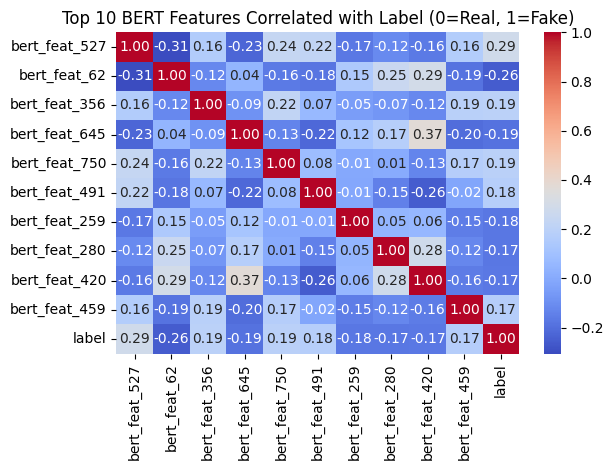

In [ ]:
def plot_top_feature_correlations(data_features, label_column='label', top_n=10):
    #correlation matrix
    correlation_matrix = data_features.corr()
    #considering first 10 feautures by defaullt
    top_corr_features = correlation_matrix[label_column].abs().sort_values(ascending=False)[1:top_n+1].index
    # Extract correlation data for heatmap
    top_corr_data = data_features[top_corr_features.tolist() + [label_column]].corr()

    # Plot heatmap
    sns.heatmap(top_corr_data, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Top {top_n} BERT Features Correlated with Label (0=Real, 1=Fake)")
    plt.tight_layout()
    plt.show()




#considering all feautures except text_ column
data_feautures = data.drop(columns=['text_'])

plot_top_feature_correlations(data_feautures)


A2. Use PCA for reducing the features. Use cumsum variance to retain 99% of the explained
variance. With the PCA transformed features, run the classification models for your project. If your
project deals with regression, use regression models. Compare the results of the model performance
with reduced dimensionality.

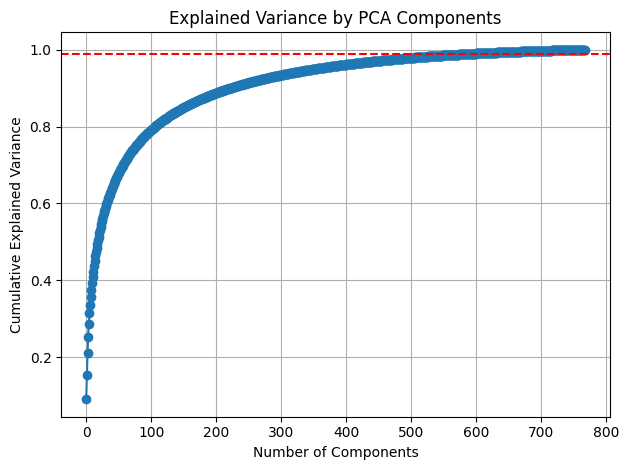

[INFO] Number of components to retain 99% variance: 597

Logistic Regression
Train Accuracy: 0.8390
Test Accuracy:  0.8060
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1008
           1       0.80      0.81      0.81       992

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000

Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3994
           1       0.84      0.84      0.84      4006

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000


Random Forest
Train Accuracy: 1.0000
Test Accuracy:  0.6885
Classification Report (Test Data):
              precision    recall  f1-score   support

 

In [ ]:
def apply_pca(X, variance=0.99, plot_variance=True):
    #feauture standarization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    #Applying pca
    pca = PCA()
    pca.fit(X_scaled)

    # Plot cumulative explained variance
    if plot_variance:
        plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
        plt.axhline(y=variance, color='r', linestyle='--')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("Explained Variance by PCA Components")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    #Considering required no.of components
    n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= variance) + 1
    print(f"[INFO] Number of components to retain {int(variance*100)}% variance: {n_components}")

    #final pca with selected models
    pca_final = PCA(n_components=n_components)
    X_pca = pca_final.fit_transform(X_scaled)

    return X_pca, n_components

def classifiers(X, y):
    # Spliting of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier()
    }

    # Train and evaluate
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        print(f"\n{name}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy:  {test_acc:.4f}")
        print("Classification Report (Test Data):")
        print(classification_report(y_test, y_test_pred))
        print("Classification Report (Train Data):")
        print(classification_report(y_train, y_train_pred))


X = data.drop(columns=["text_", "label"])
y = data["label"]

# Apply PCA
X_pca, n_comp = apply_pca(X, variance=0.99)

# Train classifiers
classifiers(X_pca, y)


A3. Repeat A2 experiment with 95% of explained variance.

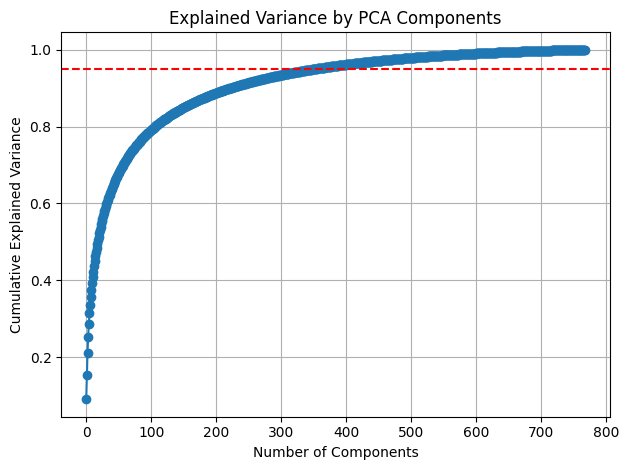

[INFO] Number of components to retain 95% variance: 352

Logistic Regression
Train Accuracy: 0.8163
Test Accuracy:  0.7995
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1008
           1       0.80      0.79      0.80       992

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000

Classification Report (Train Data):
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      3994
           1       0.82      0.82      0.82      4006

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000


Random Forest
Train Accuracy: 1.0000
Test Accuracy:  0.7045
Classification Report (Test Data):
              precision    recall  f1-score   support

 

In [ ]:
# Apply PCA with variance 95%
X_pca, n_comp = apply_pca(X, variance=0.95)

# Train classifiers
classifiers(X_pca, y)

A4. Use sequential feature selection / reduction techniques for feature reduction. Compare the
results of various models with results obtained by A2 and A3 experiments.

In [10]:
data = data.iloc[:1500, :]


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def sequential_feature_selection_lr(X, y, n_features=100, prefilter_k=300):
    print(f"\n[INFO] Pre-filtering top {prefilter_k} features using SelectKBest...")
    selector = SelectKBest(score_func=f_classif, k=prefilter_k)
    X_new = selector.fit_transform(X, y)
    selected_feature_names = X.columns[selector.get_support()]
    X_filtered = pd.DataFrame(X_new, columns=selected_feature_names)

    print("[INFO] Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

    print("[INFO] Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(max_iter=1000)

    print(f"\n[INFO] Running Sequential Feature Selection (n_features={n_features})")
    sfs = SFS(
        model,
        k_features=n_features,
        forward=True,
        floating=False,
        verbose=2,
        scoring='accuracy',
        cv=3,
        n_jobs=-1
    )
    sfs.fit(X_train_scaled, y_train)

    selected_indices = list(sfs.k_feature_idx_)
    selected_feature_names = X_train.columns[selected_indices]
    print(f"[LR] Selected feature names: {list(selected_feature_names[:10])} ...")

    X_train_sfs = X_train_scaled[:, selected_indices]
    X_test_sfs = X_test_scaled[:, selected_indices]

    model.fit(X_train_sfs, y_train)
    y_train_pred = model.predict(X_train_sfs)
    y_test_pred = model.predict(X_test_sfs)

    print(f"[LR] Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"[LR] Test Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
    print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))
    print("Classification Report (Train):\n", classification_report(y_train, y_train_pred))

    pd.Series(selected_feature_names).to_csv("LR_selected_features.csv", index=False)
    print("[LR] Selected features saved to 'LR_selected_features.csv'")

# --- Run the function ---

X = data.drop(columns=["label"])  # remove 'text_' if not already dropped
y = data["label"]

sequential_feature_selection_lr(X, y, n_features=100, prefilter_k=300)



[INFO] Pre-filtering top 300 features using SelectKBest...
[INFO] Splitting data...
[INFO] Scaling features...

[INFO] Running Sequential Feature Selection (n_features=100)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.9s finished

[2025-04-12 17:30:59] Features: 1/100 -- score: 0.5796553884711778[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 299 out of 299 | elapsed:    4.7s finished

[2025-04-12 17:31:04] Features: 2/100 -- score: 0.6038680033416876[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 298 out of 298 | elapsed:    3.4s finished

[2025-04-12 17:31:08] Features: 3/100 -- score: 0.6238700918964076[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 297 ou

[LR] Selected feature names: ['bert_feat_2', 'bert_feat_7', 'bert_feat_11', 'bert_feat_37', 'bert_feat_41', 'bert_feat_42', 'bert_feat_53', 'bert_feat_56', 'bert_feat_62', 'bert_feat_75'] ...
[LR] Train Accuracy: 0.7148
[LR] Test Accuracy:  0.6600
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.65      0.68      0.66       148
           1       0.67      0.64      0.66       152

    accuracy                           0.66       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.66      0.66      0.66       300

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.72      0.73      0.72       612
           1       0.71      0.70      0.71       587

    accuracy                           0.71      1199
   macro avg       0.71      0.71      0.71      1199
weighted avg       0.71      0.71      0.71      1199

[LR] Selected features saved to 'LR

[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    6.6s finished

[2025-04-12 17:40:49] Features: 100/100 -- score: 0.6864097744360903

A5. Use LIME and SHAP for explaining the model behaviour. Study the outputs of LIME and SHAP and
compare the explainability and usage suitability for these xAI *packages*

In [24]:


def explain_with_lime(model, X_train, X_test, feature_names, class_names=['Real', 'Fake']):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    i = 0  # You can change this to test other instances
    exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=10)
    print(f"\n[LIME] Top features influencing prediction for sample {i}:")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight:.4f}")
    return exp

def explain_with_shap(model, X_train, X_test):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test[:1])  # Just for the first sample

    print(f"\n[SHAP] Top features impacting prediction for sample 0:")

    # Extract SHAP values for the first sample
    shap_values_array = shap_values[0].values  # Access the SHAP values for the first test sample

    # If it's a multi-output model, we need to check each output class separately
    if len(shap_values_array.shape) > 1:
        shap_values_array = shap_values_array[0]  # Get the SHAP values for the first output class

    # Create a list of (feature index, SHAP value)
    feature_impact = [(idx, shap_values_array[idx]) for idx in range(len(shap_values_array))]

    # Sort by absolute SHAP value and take top 10 features
    sorted_impact = sorted(feature_impact, key=lambda x: abs(x[1]), reverse=True)[:10]

    for idx, val in sorted_impact:
        print(f"Feature {idx}: SHAP value = {val:.4f}")


# Load data
X = data.drop(columns=["label"])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Get feature names
feature_names = X.columns.tolist()

# Random forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

print("\n[RF] Train Accuracy:", accuracy_score(y_train, rf.predict(X_train_scaled)))
print("[RF] Test Accuracy:", accuracy_score(y_test, rf.predict(X_test_scaled)))

explain_with_lime(rf, X_train_scaled, X_test_scaled, feature_names)
explain_with_shap(rf, X_train_scaled, X_test_scaled)

# Logestic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

print("\n[LR] Train Accuracy:", accuracy_score(y_train, lr.predict(X_train_scaled)))
print("[LR] Test Accuracy:", accuracy_score(y_test, lr.predict(X_test_scaled)))

explain_with_lime(lr, X_train_scaled, X_test_scaled, feature_names)
explain_with_shap(lr, X_train_scaled, X_test_scaled)



[RF] Train Accuracy: 1.0
[RF] Test Accuracy: 0.6633333333333333

[LIME] Top features influencing prediction for sample 0:
bert_feat_527 > 0.63: 0.0121
bert_feat_367 <= -0.59: 0.0112
bert_feat_475 <= -0.67: 0.0064
bert_feat_447 <= -0.65: 0.0063
bert_feat_654 <= -0.59: 0.0059
bert_feat_331 <= -0.60: -0.0056
bert_feat_343 <= -0.68: 0.0054
bert_feat_338 > 0.65: -0.0051
bert_feat_755 > 0.64: 0.0050
bert_feat_188 > 0.61: 0.0047

[SHAP] Top features impacting prediction for sample 0:
Feature 0: SHAP value = 0.0011
Feature 1: SHAP value = -0.0011

[LR] Train Accuracy: 0.9991659716430359
[LR] Test Accuracy: 0.66

[LIME] Top features influencing prediction for sample 0:
bert_feat_335 <= -0.65: 0.0881
bert_feat_189 <= -0.59: 0.0816
bert_feat_579 <= -0.58: 0.0813
bert_feat_28 <= -0.69: 0.0753
bert_feat_602 > 0.66: 0.0735
bert_feat_739 > 0.66: 0.0713
bert_feat_104 > 0.58: -0.0677
bert_feat_684 <= -0.65: -0.0669
bert_feat_271 > 0.63: -0.0658
bert_feat_683 > 0.64: -0.0583

[SHAP] Top features impact